In [54]:
import torch, os
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import random
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torch.optim as optim
import time

train_data_dir = '4/train'
val_data_dir = '4/val'
test_data_dir = '4/test'

def get_data_loaders(batch_size=16, num_workers=2):
    transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5, 0.5, 0.5])])
    trainset = torchvision.datasets.ImageFolder(root= train_data_dir, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                            shuffle=True, num_workers=num_workers)

    valnset = torchvision.datasets.ImageFolder(root= val_data_dir, transform=transform)
    valloader = torch.utils.data.DataLoader(valnset, batch_size=batch_size,
                                            shuffle=True, num_workers=num_workers)

    testset = torchvision.datasets.ImageFolder(root= test_data_dir, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                            shuffle=False, num_workers=num_workers)

    return trainloader, valloader, testloader

In [2]:
def train(epoch, trainloader, optimizer, criterion):
    running_loss = 0.0
    for i, data in enumerate((trainloader), 0):
        inputs, labels = data
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print('epoch %d training loss: %.3f' %
            (epoch + 1, running_loss / (len(trainloader))))
    return running_loss/len(trainloader)

def test(testloader, model):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in (testloader):
            images, labels = data
            if torch.cuda.is_available():
                images, labels = images.cuda(), labels.cuda()        
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the val/test images: %f %%' % (
                                    100 * correct / total))
    return 100*correct/total

In [29]:
class Net(nn.Module):
    def __init__(self, num_deep_layers=3):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=24, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(in_features=24, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=256)
        
        self.fc_final = nn.Linear(in_features=256, out_features=33)

    def forward(self, x): 

        x = F.relu(self.conv1(x))
        x = self.pool(x)
        
        x = F.avg_pool2d(x, kernel_size=x.shape[2:])
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc_final(x)
        
        return x  

num_epochs = 50
learning_rate = 0.001

trainloader, valloader, testloader = get_data_loaders()

net = Net()
if torch.cuda.is_available():
    net = net.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

num_params = np.sum([p.nelement() for p in net.parameters()])
print(num_params, ' parameters')

81345  parameters


In [30]:
print('Start Training')
os.makedirs('./models_1b', exist_ok=True)

train_loss_arr = []
val_acc_arr = []

best_epoch = 0
best_val_acc = 0

t1 = time.time()
for epoch in range(num_epochs):
    print('epoch ', epoch + 1)
    train_loss = train(epoch, trainloader, optimizer, criterion)
    val_acc = test(valloader, net)
    if val_acc>best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch
    torch.save(net.state_dict(), './models_1b/model'+str(epoch)+'.pth')
    train_loss_arr.append(train_loss)
    val_acc_arr.append(val_acc)
    if epoch > 10:
        avg_prev_val_acc = np.mean(val_acc_arr[-6:-3])
        avg_cur_val_acc = np.mean(val_acc_arr[-3:])
        if avg_cur_val_acc < avg_prev_val_acc:
            break
t2 = time.time()
print("time taken: ", str(t2-t1))

Start Training
epoch  1
epoch 1 training loss: 3.494
Accuracy of the network on the val/test images: 4.181818 %
epoch  2
epoch 2 training loss: 3.483
Accuracy of the network on the val/test images: 5.393939 %
epoch  3
epoch 3 training loss: 3.464
Accuracy of the network on the val/test images: 6.060606 %
epoch  4
epoch 4 training loss: 3.425
Accuracy of the network on the val/test images: 6.909091 %
epoch  5
epoch 5 training loss: 3.384
Accuracy of the network on the val/test images: 7.909091 %
epoch  6
epoch 6 training loss: 3.339
Accuracy of the network on the val/test images: 7.909091 %
epoch  7
epoch 7 training loss: 3.281
Accuracy of the network on the val/test images: 8.939394 %
epoch  8
epoch 8 training loss: 3.249
Accuracy of the network on the val/test images: 9.030303 %
epoch  9
epoch 9 training loss: 3.231
Accuracy of the network on the val/test images: 9.030303 %
epoch  10
epoch 10 training loss: 3.219
Accuracy of the network on the val/test images: 9.090909 %
epoch  11
epo

In [11]:
net.load_state_dict(torch.load(f"models_1/model{best_epoch}.pth"))
test_acc = test(testloader, net)

Accuracy of the network on the val/test images: 15.848485 %


In [31]:
class Net(nn.Module):
    def __init__(self, num_deep_layers=3):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=24, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=24, out_channels=64, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(in_features=64, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=256)
        
        self.fc_final = nn.Linear(in_features=256, out_features=33)

    def forward(self, x): 

        x = F.relu(self.conv1(x))
        x = self.pool(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        
        x = F.avg_pool2d(x, kernel_size=x.shape[2:])
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc_final(x)
        
        return x  

num_epochs = 50
learning_rate = 0.001

trainloader, valloader, testloader = get_data_loaders()

net = Net()
if torch.cuda.is_available():
    net = net.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

num_params = np.sum([p.nelement() for p in net.parameters()])
print(num_params, ' parameters')

105473  parameters


In [32]:
print('Start Training')
os.makedirs('./models_2b', exist_ok=True)

train_loss_arr = []
val_acc_arr = []

best_epoch = 0
best_val_acc = 0

t1 = time.time()
for epoch in range(num_epochs):
    print('epoch ', epoch + 1)
    train_loss = train(epoch, trainloader, optimizer, criterion)
    val_acc = test(valloader, net)
    if val_acc>best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch
    torch.save(net.state_dict(), './models_2b/model'+str(epoch)+'.pth')
    train_loss_arr.append(train_loss)
    val_acc_arr.append(val_acc)
    if epoch > 10:
        avg_prev_val_acc = np.mean(val_acc_arr[-6:-3])
        avg_cur_val_acc = np.mean(val_acc_arr[-3:])
        if avg_cur_val_acc < avg_prev_val_acc:
            break
t2 = time.time()
print(str(t2-t1))

Start Training
epoch  1
epoch 1 training loss: 3.496
Accuracy of the network on the val/test images: 3.303030 %
epoch  2
epoch 2 training loss: 3.493
Accuracy of the network on the val/test images: 4.212121 %
epoch  3
epoch 3 training loss: 3.489
Accuracy of the network on the val/test images: 4.000000 %
epoch  4
epoch 4 training loss: 3.477
Accuracy of the network on the val/test images: 4.393939 %
epoch  5
epoch 5 training loss: 3.456
Accuracy of the network on the val/test images: 5.000000 %
epoch  6
epoch 6 training loss: 3.424
Accuracy of the network on the val/test images: 6.696970 %
epoch  7
epoch 7 training loss: 3.396
Accuracy of the network on the val/test images: 6.545455 %
epoch  8
epoch 8 training loss: 3.365
Accuracy of the network on the val/test images: 9.060606 %
epoch  9
epoch 9 training loss: 3.291
Accuracy of the network on the val/test images: 9.212121 %
epoch  10
epoch 10 training loss: 3.237
Accuracy of the network on the val/test images: 9.878788 %
epoch  11
epo

In [33]:
net.load_state_dict(torch.load(f"models_2b/model{best_epoch}.pth"))
test_acc = test(testloader, net)

Accuracy of the network on the val/test images: 23.575758 %


In [17]:
class Net(nn.Module):
    def __init__(self, num_deep_layers=3):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=24, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=24, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(in_features=128, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=256)
        
        self.fc_final = nn.Linear(in_features=256, out_features=33)

    def forward(self, x): 

        x = F.relu(self.conv1(x))
        x = self.pool(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        
        x = F.avg_pool2d(x, kernel_size=x.shape[2:])
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc_final(x)
        
        return x  

num_epochs = 50
learning_rate = 0.001

trainloader, valloader, testloader = get_data_loaders()

net = Net()
if torch.cuda.is_available():
    net = net.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

num_params = np.sum([p.nelement() for p in net.parameters()])
print(num_params, ' parameters')

326785  parameters


In [18]:
print('Start Training')
os.makedirs('./models_3', exist_ok=True)

train_loss_arr = []
val_acc_arr = []

best_epoch = 0
best_val_acc = 0

for epoch in range(num_epochs):
    print('epoch ', epoch + 1)
    train_loss = train(epoch, trainloader, optimizer, criterion)
    val_acc = test(valloader, net)
    if val_acc>best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch
    torch.save(net.state_dict(), './models_3/model'+str(epoch)+'.pth')
    train_loss_arr.append(train_loss)
    val_acc_arr.append(val_acc)
    if epoch > 10:
        avg_prev_val_acc = np.mean(val_acc_arr[-6:-3])
        avg_cur_val_acc = np.mean(val_acc_arr[-3:])
        if avg_cur_val_acc < avg_prev_val_acc:
            break

Start Training
epoch  1
epoch 1 training loss: 3.497
Accuracy of the network on the val/test images: 3.151515 %
epoch  2
epoch 2 training loss: 3.496
Accuracy of the network on the val/test images: 5.060606 %
epoch  3
epoch 3 training loss: 3.495
Accuracy of the network on the val/test images: 5.393939 %
epoch  4
epoch 4 training loss: 3.494
Accuracy of the network on the val/test images: 5.636364 %
epoch  5
epoch 5 training loss: 3.490
Accuracy of the network on the val/test images: 5.000000 %
epoch  6
epoch 6 training loss: 3.479
Accuracy of the network on the val/test images: 4.969697 %
epoch  7
epoch 7 training loss: 3.426
Accuracy of the network on the val/test images: 7.393939 %
epoch  8
epoch 8 training loss: 3.293
Accuracy of the network on the val/test images: 9.030303 %
epoch  9
epoch 9 training loss: 3.236
Accuracy of the network on the val/test images: 9.606061 %
epoch  10
epoch 10 training loss: 3.204
Accuracy of the network on the val/test images: 8.909091 %
epoch  11
epo

In [19]:
net.load_state_dict(torch.load(f"models_3/model{best_epoch}.pth"))
test_acc = test(testloader, net)

Accuracy of the network on the val/test images: 35.696970 %


In [23]:
class Net(nn.Module):
    def __init__(self, num_deep_layers=3):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=24, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=24, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=5, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(in_features=256, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=256)
        
        self.fc_final = nn.Linear(in_features=256, out_features=33)

    def forward(self, x): 

        x = F.relu(self.conv1(x))
        x = self.pool(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        
        x = F.avg_pool2d(x, kernel_size=x.shape[2:])
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc_final(x)
        
        return x  

num_epochs = 50
learning_rate = 0.001

trainloader, valloader, testloader = get_data_loaders()

net = Net()
if torch.cuda.is_available():
    net = net.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

num_params = np.sum([p.nelement() for p in net.parameters()])
print(num_params, ' parameters')

1179009  parameters


In [24]:
print('Start Training')
os.makedirs('./models_4', exist_ok=True)

train_loss_arr = []
val_acc_arr = []

best_epoch = 0
best_val_acc = 0

for epoch in range(num_epochs):
    print('epoch ', epoch + 1)
    train_loss = train(epoch, trainloader, optimizer, criterion)
    val_acc = test(valloader, net)
    if val_acc>best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch
    torch.save(net.state_dict(), './models_4/model'+str(epoch)+'.pth')
    train_loss_arr.append(train_loss)
    val_acc_arr.append(val_acc)
    if epoch > 10:
        avg_prev_val_acc = np.mean(val_acc_arr[-6:-3])
        avg_cur_val_acc = np.mean(val_acc_arr[-3:])
        if avg_cur_val_acc < avg_prev_val_acc:
            break

Start Training
epoch  1
epoch 1 training loss: 3.497
Accuracy of the network on the val/test images: 3.090909 %
epoch  2
epoch 2 training loss: 3.496
Accuracy of the network on the val/test images: 4.606061 %
epoch  3
epoch 3 training loss: 3.495
Accuracy of the network on the val/test images: 3.818182 %
epoch  4
epoch 4 training loss: 3.492
Accuracy of the network on the val/test images: 4.969697 %
epoch  5
epoch 5 training loss: 3.478
Accuracy of the network on the val/test images: 5.727273 %
epoch  6
epoch 6 training loss: 3.371
Accuracy of the network on the val/test images: 8.333333 %
epoch  7
epoch 7 training loss: 3.210
Accuracy of the network on the val/test images: 10.030303 %
epoch  8
epoch 8 training loss: 3.121
Accuracy of the network on the val/test images: 12.242424 %
epoch  9
epoch 9 training loss: 3.077
Accuracy of the network on the val/test images: 13.575758 %
epoch  10
epoch 10 training loss: 3.026
Accuracy of the network on the val/test images: 14.060606 %
epoch  11

In [25]:
net.load_state_dict(torch.load(f"models_4/model{best_epoch}.pth"))
test_acc = test(testloader, net)

Accuracy of the network on the val/test images: 44.272727 %


In [30]:
class Net(nn.Module):
    def __init__(self, num_deep_layers=3):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=24, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=24, out_channels=48, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=48, out_channels=64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=1)
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=5, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(in_features=256, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=256)
        
        self.fc_final = nn.Linear(in_features=256, out_features=33)

    def forward(self, x): 

        x = F.relu(self.conv1(x))
        x = self.pool(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        
        x = F.relu(self.conv5(x))
        x = self.pool(x)
        
        x = F.avg_pool2d(x, kernel_size=x.shape[2:])
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc_final(x)
        
        return x  

num_epochs = 50
learning_rate = 0.001

trainloader, valloader, testloader = get_data_loaders()

net = Net()
if torch.cuda.is_available():
    net = net.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

num_params = np.sum([p.nelement() for p in net.parameters()])
print(num_params, ' parameters')

1203249  parameters


In [31]:
print('Start Training')
os.makedirs('./models_5', exist_ok=True)

train_loss_arr = []
val_acc_arr = []

best_epoch = 0
best_val_acc = 0

for epoch in range(num_epochs):
    print('epoch ', epoch + 1)
    train_loss = train(epoch, trainloader, optimizer, criterion)
    val_acc = test(valloader, net)
    if val_acc>best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch
    torch.save(net.state_dict(), './models_5/model'+str(epoch)+'.pth')
    train_loss_arr.append(train_loss)
    val_acc_arr.append(val_acc)
    if epoch > 10:
        avg_prev_val_acc = np.mean(val_acc_arr[-6:-3])
        avg_cur_val_acc = np.mean(val_acc_arr[-3:])
        if avg_cur_val_acc < avg_prev_val_acc:
            break

Start Training
epoch  1
epoch 1 training loss: 3.497
Accuracy of the network on the val/test images: 3.030303 %
epoch  2
epoch 2 training loss: 3.497
Accuracy of the network on the val/test images: 3.030303 %
epoch  3
epoch 3 training loss: 3.497
Accuracy of the network on the val/test images: 3.151515 %
epoch  4
epoch 4 training loss: 3.497
Accuracy of the network on the val/test images: 4.242424 %
epoch  5
epoch 5 training loss: 3.497
Accuracy of the network on the val/test images: 6.393939 %
epoch  6
epoch 6 training loss: 3.496
Accuracy of the network on the val/test images: 6.606061 %
epoch  7
epoch 7 training loss: 3.496
Accuracy of the network on the val/test images: 5.969697 %
epoch  8
epoch 8 training loss: 3.496
Accuracy of the network on the val/test images: 8.151515 %
epoch  9
epoch 9 training loss: 3.495
Accuracy of the network on the val/test images: 7.636364 %
epoch  10
epoch 10 training loss: 3.494
Accuracy of the network on the val/test images: 8.000000 %
epoch  11
epo

In [32]:
net.load_state_dict(torch.load(f"models_5/model{best_epoch}.pth"))
test_acc = test(testloader, net)

Accuracy of the network on the val/test images: 37.515152 %


In [33]:
class Net(nn.Module):
    def __init__(self, num_deep_layers=3):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=24, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=24, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=5, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # self.fc1 = nn.Linear(in_features=256, out_features=256)
        # self.fc2 = nn.Linear(in_features=256, out_features=256)
        
        self.fc_final = nn.Linear(in_features=256, out_features=33)

    def forward(self, x): 

        x = F.relu(self.conv1(x))
        x = self.pool(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        
        x = F.avg_pool2d(x, kernel_size=x.shape[2:])
        x = x.view(x.shape[0], -1)
        # x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        x = self.fc_final(x)
        
        return x  

num_epochs = 50
learning_rate = 0.001

trainloader, valloader, testloader = get_data_loaders()

net = Net()
if torch.cuda.is_available():
    net = net.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

num_params = np.sum([p.nelement() for p in net.parameters()])
print(num_params, ' parameters')

1047425  parameters


In [34]:
print('Start Training')
os.makedirs('./models_6', exist_ok=True)

train_loss_arr = []
val_acc_arr = []

best_epoch = 0
best_val_acc = 0

for epoch in range(num_epochs):
    print('epoch ', epoch + 1)
    train_loss = train(epoch, trainloader, optimizer, criterion)
    val_acc = test(valloader, net)
    if val_acc>best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch
    torch.save(net.state_dict(), './models_6/model'+str(epoch)+'.pth')
    train_loss_arr.append(train_loss)
    val_acc_arr.append(val_acc)
    if epoch > 10:
        avg_prev_val_acc = np.mean(val_acc_arr[-6:-3])
        avg_cur_val_acc = np.mean(val_acc_arr[-3:])
        if avg_cur_val_acc < avg_prev_val_acc:
            break

Start Training
epoch  1
epoch 1 training loss: 3.487
Accuracy of the network on the val/test images: 4.303030 %
epoch  2
epoch 2 training loss: 3.337
Accuracy of the network on the val/test images: 8.969697 %
epoch  3
epoch 3 training loss: 3.144
Accuracy of the network on the val/test images: 13.424242 %
epoch  4
epoch 4 training loss: 3.012
Accuracy of the network on the val/test images: 15.303030 %
epoch  5
epoch 5 training loss: 2.873
Accuracy of the network on the val/test images: 18.151515 %
epoch  6
epoch 6 training loss: 2.710
Accuracy of the network on the val/test images: 20.848485 %
epoch  7
epoch 7 training loss: 2.581
Accuracy of the network on the val/test images: 22.696970 %
epoch  8
epoch 8 training loss: 2.475
Accuracy of the network on the val/test images: 27.060606 %
epoch  9
epoch 9 training loss: 2.365
Accuracy of the network on the val/test images: 28.060606 %
epoch  10
epoch 10 training loss: 2.263
Accuracy of the network on the val/test images: 31.030303 %
epoch

In [36]:
net.load_state_dict(torch.load(f"models_6/model{best_epoch}.pth"))
test_acc = test(testloader, net)

Accuracy of the network on the val/test images: 43.363636 %


In [37]:
class Net(nn.Module):
    def __init__(self, num_deep_layers=3):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=24, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=24, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=5, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(in_features=256, out_features=256)
        # self.fc2 = nn.Linear(in_features=256, out_features=256)
        
        self.fc_final = nn.Linear(in_features=256, out_features=33)

    def forward(self, x): 

        x = F.relu(self.conv1(x))
        x = self.pool(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        
        x = F.avg_pool2d(x, kernel_size=x.shape[2:])
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        x = self.fc_final(x)
        
        return x  

num_epochs = 50
learning_rate = 0.001

trainloader, valloader, testloader = get_data_loaders()

net = Net()
if torch.cuda.is_available():
    net = net.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

num_params = np.sum([p.nelement() for p in net.parameters()])
print(num_params, ' parameters')

1113217  parameters


In [38]:
print('Start Training')
os.makedirs('./models_7', exist_ok=True)

train_loss_arr = []
val_acc_arr = []

best_epoch = 0
best_val_acc = 0

for epoch in range(num_epochs):
    print('epoch ', epoch + 1)
    train_loss = train(epoch, trainloader, optimizer, criterion)
    val_acc = test(valloader, net)
    if val_acc>best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch
    torch.save(net.state_dict(), './models_7/model'+str(epoch)+'.pth')
    train_loss_arr.append(train_loss)
    val_acc_arr.append(val_acc)
    if epoch > 10:
        avg_prev_val_acc = np.mean(val_acc_arr[-6:-3])
        avg_cur_val_acc = np.mean(val_acc_arr[-3:])
        if avg_cur_val_acc < avg_prev_val_acc:
            break

Start Training
epoch  1
epoch 1 training loss: 3.496
Accuracy of the network on the val/test images: 3.666667 %
epoch  2
epoch 2 training loss: 3.486
Accuracy of the network on the val/test images: 6.909091 %
epoch  3
epoch 3 training loss: 3.369
Accuracy of the network on the val/test images: 9.060606 %
epoch  4
epoch 4 training loss: 3.161
Accuracy of the network on the val/test images: 11.575758 %
epoch  5
epoch 5 training loss: 3.060
Accuracy of the network on the val/test images: 12.939394 %
epoch  6
epoch 6 training loss: 2.986
Accuracy of the network on the val/test images: 14.727273 %
epoch  7
epoch 7 training loss: 2.925
Accuracy of the network on the val/test images: 15.666667 %
epoch  8
epoch 8 training loss: 2.837
Accuracy of the network on the val/test images: 17.484848 %
epoch  9
epoch 9 training loss: 2.724
Accuracy of the network on the val/test images: 20.060606 %
epoch  10
epoch 10 training loss: 2.643
Accuracy of the network on the val/test images: 23.181818 %
epoch 

In [39]:
net.load_state_dict(torch.load(f"models_7/model{best_epoch}.pth"))
test_acc = test(testloader, net)

Accuracy of the network on the val/test images: 43.484848 %


In [40]:
class Net(nn.Module):
    def __init__(self, num_deep_layers=3):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=24, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=24, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=5, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(in_features=256, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=256)
        self.fc3 = nn.Linear(in_features=256, out_features=256)
        
        self.fc_final = nn.Linear(in_features=256, out_features=33)

    def forward(self, x): 

        x = F.relu(self.conv1(x))
        x = self.pool(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        
        x = F.avg_pool2d(x, kernel_size=x.shape[2:])
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc_final(x)
        
        return x  

num_epochs = 50
learning_rate = 0.001

trainloader, valloader, testloader = get_data_loaders()

net = Net()
if torch.cuda.is_available():
    net = net.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

num_params = np.sum([p.nelement() for p in net.parameters()])
print(num_params, ' parameters')

1244801  parameters


In [41]:
print('Start Training')
os.makedirs('./models_8', exist_ok=True)

train_loss_arr = []
val_acc_arr = []

best_epoch = 0
best_val_acc = 0

for epoch in range(num_epochs):
    print('epoch ', epoch + 1)
    train_loss = train(epoch, trainloader, optimizer, criterion)
    val_acc = test(valloader, net)
    if val_acc>best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch
    torch.save(net.state_dict(), './models_8/model'+str(epoch)+'.pth')
    train_loss_arr.append(train_loss)
    val_acc_arr.append(val_acc)
    if epoch > 10:
        avg_prev_val_acc = np.mean(val_acc_arr[-6:-3])
        avg_cur_val_acc = np.mean(val_acc_arr[-3:])
        if avg_cur_val_acc < avg_prev_val_acc:
            break

Start Training
epoch  1
epoch 1 training loss: 3.497
Accuracy of the network on the val/test images: 3.030303 %
epoch  2
epoch 2 training loss: 3.497
Accuracy of the network on the val/test images: 3.030303 %
epoch  3
epoch 3 training loss: 3.497
Accuracy of the network on the val/test images: 4.696970 %
epoch  4
epoch 4 training loss: 3.496
Accuracy of the network on the val/test images: 4.727273 %
epoch  5
epoch 5 training loss: 3.496
Accuracy of the network on the val/test images: 4.969697 %
epoch  6
epoch 6 training loss: 3.495
Accuracy of the network on the val/test images: 2.848485 %
epoch  7
epoch 7 training loss: 3.494
Accuracy of the network on the val/test images: 5.000000 %
epoch  8
epoch 8 training loss: 3.490
Accuracy of the network on the val/test images: 4.363636 %
epoch  9
epoch 9 training loss: 3.473
Accuracy of the network on the val/test images: 5.636364 %
epoch  10
epoch 10 training loss: 3.434
Accuracy of the network on the val/test images: 6.545455 %
epoch  11
epo

In [42]:
net.load_state_dict(torch.load(f"models_8/model{best_epoch}.pth"))
test_acc = test(testloader, net)

Accuracy of the network on the val/test images: 44.636364 %


In [43]:
class Net(nn.Module):
    def __init__(self, num_deep_layers=3):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=24, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=24, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=5, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(in_features=256, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=256)
        
        self.fc_final = nn.Linear(in_features=256, out_features=33)

    def forward(self, x): 

        x = F.relu(self.conv1(x))
        # x = self.pool(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        
        x = F.relu(self.conv3(x))
        # x = self.pool(x)
        
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        
        x = F.avg_pool2d(x, kernel_size=x.shape[2:])
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc_final(x)
        
        return x  

num_epochs = 50
learning_rate = 0.001

trainloader, valloader, testloader = get_data_loaders()

net = Net()
if torch.cuda.is_available():
    net = net.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

num_params = np.sum([p.nelement() for p in net.parameters()])
print(num_params, ' parameters')

1179009  parameters


In [44]:
print('Start Training')
os.makedirs('./models_9', exist_ok=True)

train_loss_arr = []
val_acc_arr = []

best_epoch = 0
best_val_acc = 0

for epoch in range(num_epochs):
    print('epoch ', epoch + 1)
    train_loss = train(epoch, trainloader, optimizer, criterion)
    val_acc = test(valloader, net)
    if val_acc>best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch
    torch.save(net.state_dict(), './models_9/model'+str(epoch)+'.pth')
    train_loss_arr.append(train_loss)
    val_acc_arr.append(val_acc)
    if epoch > 10:
        avg_prev_val_acc = np.mean(val_acc_arr[-6:-3])
        avg_cur_val_acc = np.mean(val_acc_arr[-3:])
        if avg_cur_val_acc < avg_prev_val_acc:
            break

Start Training
epoch  1
epoch 1 training loss: 3.498
Accuracy of the network on the val/test images: 3.909091 %
epoch  2
epoch 2 training loss: 3.497
Accuracy of the network on the val/test images: 4.606061 %
epoch  3
epoch 3 training loss: 3.497
Accuracy of the network on the val/test images: 4.878788 %
epoch  4
epoch 4 training loss: 3.496
Accuracy of the network on the val/test images: 4.454545 %
epoch  5
epoch 5 training loss: 3.496
Accuracy of the network on the val/test images: 5.121212 %
epoch  6
epoch 6 training loss: 3.494
Accuracy of the network on the val/test images: 4.636364 %
epoch  7
epoch 7 training loss: 3.491
Accuracy of the network on the val/test images: 4.303030 %
epoch  8
epoch 8 training loss: 3.477
Accuracy of the network on the val/test images: 5.030303 %
epoch  9
epoch 9 training loss: 3.442
Accuracy of the network on the val/test images: 5.878788 %
epoch  10
epoch 10 training loss: 3.411
Accuracy of the network on the val/test images: 6.575758 %
epoch  11
epo

KeyboardInterrupt: 

In [45]:
net.load_state_dict(torch.load(f"models_9/model{best_epoch}.pth"))
test_acc = test(testloader, net)

Accuracy of the network on the val/test images: 28.090909 %


In [4]:
class Net(nn.Module):
    def __init__(self, num_deep_layers=3):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=24, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=24, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=5, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2)
        
        self.fc1 = nn.Linear(in_features=256, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=256)
        
        self.fc_final = nn.Linear(in_features=256, out_features=33)

    def forward(self, x): 

        x = F.relu(self.conv1(x))
        x = self.pool(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        
        x = F.avg_pool2d(x, kernel_size=x.shape[2:])
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc_final(x)
        
        return x  

num_epochs = 50
learning_rate = 0.001

trainloader, valloader, testloader = get_data_loaders()

net = Net()
if torch.cuda.is_available():
    net = net.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

num_params = np.sum([p.nelement() for p in net.parameters()])
print(num_params, ' parameters')

1179009  parameters


In [5]:
print('Start Training')
os.makedirs('./models_10', exist_ok=True)

train_loss_arr = []
val_acc_arr = []

best_epoch = 0
best_val_acc = 0

for epoch in range(num_epochs):
    print('epoch ', epoch + 1)
    train_loss = train(epoch, trainloader, optimizer, criterion)
    val_acc = test(valloader, net)
    if val_acc>best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch
    torch.save(net.state_dict(), './models_10/model'+str(epoch)+'.pth')
    train_loss_arr.append(train_loss)
    val_acc_arr.append(val_acc)
    if epoch > 10:
        avg_prev_val_acc = np.mean(val_acc_arr[-6:-3])
        avg_cur_val_acc = np.mean(val_acc_arr[-3:])
        if avg_cur_val_acc < avg_prev_val_acc:
            break

Start Training
epoch  1
epoch 1 training loss: 3.497
Accuracy of the network on the val/test images: 3.454545 %
epoch  2
epoch 2 training loss: 3.495
Accuracy of the network on the val/test images: 3.303030 %
epoch  3
epoch 3 training loss: 3.485
Accuracy of the network on the val/test images: 4.939394 %
epoch  4
epoch 4 training loss: 3.392
Accuracy of the network on the val/test images: 8.333333 %
epoch  5
epoch 5 training loss: 3.216
Accuracy of the network on the val/test images: 11.212121 %
epoch  6
epoch 6 training loss: 3.099
Accuracy of the network on the val/test images: 13.363636 %
epoch  7
epoch 7 training loss: 3.019
Accuracy of the network on the val/test images: 13.848485 %
epoch  8
epoch 8 training loss: 2.936
Accuracy of the network on the val/test images: 16.666667 %
epoch  9
epoch 9 training loss: 2.809
Accuracy of the network on the val/test images: 18.484848 %
epoch  10
epoch 10 training loss: 2.700
Accuracy of the network on the val/test images: 21.545455 %
epoch  

In [7]:
net.load_state_dict(torch.load(f"models_10/model{best_epoch}.pth"))
test_acc = test(testloader, net)

Accuracy of the network on the val/test images: 43.515152 %


In [12]:
class Net(nn.Module):
    def __init__(self, num_deep_layers=3):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=24, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=24, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=5, padding=2)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=3)
        
        self.fc1 = nn.Linear(in_features=256, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=256)
        
        self.fc_final = nn.Linear(in_features=256, out_features=33)

    def forward(self, x): 

        x = F.relu(self.conv1(x))
        x = self.pool(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        
        x = F.avg_pool2d(x, kernel_size=x.shape[2:])
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc_final(x)
        
        return x  

num_epochs = 50
learning_rate = 0.001

trainloader, valloader, testloader = get_data_loaders()

net = Net()
if torch.cuda.is_available():
    net = net.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

num_params = np.sum([p.nelement() for p in net.parameters()])
print(num_params, ' parameters')

1179009  parameters


In [13]:
print('Start Training')
os.makedirs('./models_11', exist_ok=True)

train_loss_arr = []
val_acc_arr = []

best_epoch = 0
best_val_acc = 0

for epoch in range(num_epochs):
    print('epoch ', epoch + 1)
    train_loss = train(epoch, trainloader, optimizer, criterion)
    val_acc = test(valloader, net)
    if val_acc>best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch
    torch.save(net.state_dict(), './models_11/model'+str(epoch)+'.pth')
    train_loss_arr.append(train_loss)
    val_acc_arr.append(val_acc)
    if epoch > 10:
        avg_prev_val_acc = np.mean(val_acc_arr[-6:-3])
        avg_cur_val_acc = np.mean(val_acc_arr[-3:])
        if avg_cur_val_acc < avg_prev_val_acc:
            break

Start Training
epoch  1
epoch 1 training loss: 3.497
Accuracy of the network on the val/test images: 3.030303 %
epoch  2
epoch 2 training loss: 3.497
Accuracy of the network on the val/test images: 3.030303 %
epoch  3
epoch 3 training loss: 3.496
Accuracy of the network on the val/test images: 3.181818 %
epoch  4
epoch 4 training loss: 3.495
Accuracy of the network on the val/test images: 4.090909 %
epoch  5
epoch 5 training loss: 3.493
Accuracy of the network on the val/test images: 5.666667 %
epoch  6
epoch 6 training loss: 3.485
Accuracy of the network on the val/test images: 5.090909 %
epoch  7
epoch 7 training loss: 3.443
Accuracy of the network on the val/test images: 5.939394 %
epoch  8
epoch 8 training loss: 3.385
Accuracy of the network on the val/test images: 6.242424 %
epoch  9
epoch 9 training loss: 3.303
Accuracy of the network on the val/test images: 7.151515 %
epoch  10
epoch 10 training loss: 3.230
Accuracy of the network on the val/test images: 8.969697 %
epoch  11
epo

In [14]:
net.load_state_dict(torch.load(f"models_11/model{best_epoch}.pth"))
test_acc = test(testloader, net)

Accuracy of the network on the val/test images: 33.909091 %


In [15]:
class Net(nn.Module):
    def __init__(self, num_deep_layers=3):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=24, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=24, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=5, padding=1)
        
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(in_features=256, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=256)
        
        self.fc_final = nn.Linear(in_features=256, out_features=33)

    def forward(self, x): 

        x = F.relu(self.conv1(x))
        x = self.pool(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        
        x = F.avg_pool2d(x, kernel_size=x.shape[2:])
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc_final(x)
        
        return x  

num_epochs = 50
learning_rate = 0.001

trainloader, valloader, testloader = get_data_loaders()

net = Net()
if torch.cuda.is_available():
    net = net.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

num_params = np.sum([p.nelement() for p in net.parameters()])
print(num_params, ' parameters')

1179009  parameters


In [16]:
print('Start Training')
os.makedirs('./models_12', exist_ok=True)

train_loss_arr = []
val_acc_arr = []

best_epoch = 0
best_val_acc = 0

for epoch in range(num_epochs):
    print('epoch ', epoch + 1)
    train_loss = train(epoch, trainloader, optimizer, criterion)
    val_acc = test(valloader, net)
    if val_acc>best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch
    torch.save(net.state_dict(), './models_12/model'+str(epoch)+'.pth')
    train_loss_arr.append(train_loss)
    val_acc_arr.append(val_acc)
    if epoch > 10:
        avg_prev_val_acc = np.mean(val_acc_arr[-6:-3])
        avg_cur_val_acc = np.mean(val_acc_arr[-3:])
        if avg_cur_val_acc < avg_prev_val_acc:
            break

Start Training
epoch  1
epoch 1 training loss: 3.497
Accuracy of the network on the val/test images: 2.424242 %
epoch  2
epoch 2 training loss: 3.497
Accuracy of the network on the val/test images: 2.666667 %
epoch  3
epoch 3 training loss: 3.496
Accuracy of the network on the val/test images: 2.363636 %
epoch  4
epoch 4 training loss: 3.496
Accuracy of the network on the val/test images: 3.303030 %
epoch  5
epoch 5 training loss: 3.494
Accuracy of the network on the val/test images: 5.060606 %
epoch  6
epoch 6 training loss: 3.489
Accuracy of the network on the val/test images: 5.757576 %
epoch  7
epoch 7 training loss: 3.444
Accuracy of the network on the val/test images: 5.575758 %
epoch  8
epoch 8 training loss: 3.320
Accuracy of the network on the val/test images: 7.909091 %
epoch  9
epoch 9 training loss: 3.224
Accuracy of the network on the val/test images: 9.575758 %
epoch  10
epoch 10 training loss: 3.163
Accuracy of the network on the val/test images: 11.454545 %
epoch  11
ep

In [17]:
net.load_state_dict(torch.load(f"models_12/model{best_epoch}.pth"))
test_acc = test(testloader, net)

Accuracy of the network on the val/test images: 37.151515 %


In [34]:
class Net(nn.Module):
    def __init__(self, num_deep_layers=3):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=48, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=48, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=256, kernel_size=5, padding=1)
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=5, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(in_features=256, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=256)
        
        self.fc_final = nn.Linear(in_features=256, out_features=33)

    def forward(self, x): 

        x = F.relu(self.conv1(x))
        x = self.pool(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        
        x = F.avg_pool2d(x, kernel_size=x.shape[2:])
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc_final(x)
        
        return x  

num_epochs = 50
learning_rate = 0.001

trainloader, valloader, testloader = get_data_loaders()

net = Net()
if torch.cuda.is_available():
    net = net.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

num_params = np.sum([p.nelement() for p in net.parameters()])
print(num_params, ' parameters')

2217633  parameters


In [19]:
print('Start Training')
os.makedirs('./models_13', exist_ok=True)

train_loss_arr = []
val_acc_arr = []

best_epoch = 0
best_val_acc = 0

for epoch in range(num_epochs):
    print('epoch ', epoch + 1)
    train_loss = train(epoch, trainloader, optimizer, criterion)
    val_acc = test(valloader, net)
    if val_acc>best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch
    torch.save(net.state_dict(), './models_13/model'+str(epoch)+'.pth')
    train_loss_arr.append(train_loss)
    val_acc_arr.append(val_acc)
    if epoch > 10:
        avg_prev_val_acc = np.mean(val_acc_arr[-6:-3])
        avg_cur_val_acc = np.mean(val_acc_arr[-3:])
        if avg_cur_val_acc < avg_prev_val_acc:
            break

Start Training
epoch  1
epoch 1 training loss: 3.497
Accuracy of the network on the val/test images: 3.060606 %
epoch  2
epoch 2 training loss: 3.496
Accuracy of the network on the val/test images: 3.242424 %
epoch  3
epoch 3 training loss: 3.495
Accuracy of the network on the val/test images: 3.848485 %
epoch  4
epoch 4 training loss: 3.492
Accuracy of the network on the val/test images: 6.878788 %
epoch  5
epoch 5 training loss: 3.460
Accuracy of the network on the val/test images: 6.181818 %
epoch  6
epoch 6 training loss: 3.336
Accuracy of the network on the val/test images: 10.000000 %
epoch  7
epoch 7 training loss: 3.152
Accuracy of the network on the val/test images: 11.060606 %
epoch  8
epoch 8 training loss: 3.087
Accuracy of the network on the val/test images: 13.060606 %
epoch  9
epoch 9 training loss: 3.029
Accuracy of the network on the val/test images: 12.090909 %
epoch  10
epoch 10 training loss: 2.959
Accuracy of the network on the val/test images: 15.272727 %
epoch  1

In [36]:
# net.load_state_dict(torch.load(f"models_13/model{best_epoch}.pth"))
# test_acc = test(testloader, net)
net.load_state_dict(torch.load(f"models_13/model38.pth"))
test_acc = test(testloader, net)

Accuracy of the network on the val/test images: 45.666667 %


In [37]:
#########################################################################
# get details of classes and class to index mapping in a directory
def find_classes(dir):
    classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx


def classwise_test(testloader, model):
########################################################################
# class-wise accuracy

    classes, _ = find_classes(train_data_dir)
    n_class = len(classes) # number of classes

    class_correct = list(0. for i in range(n_class))
    class_total = list(0. for i in range(n_class))
    with torch.no_grad():
        for data in tqdm(testloader):
            images, labels = data
            if torch.cuda.is_available():
                images, labels = images.cuda(), labels.cuda()        
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    for i in range(n_class):
        print('Accuracy of %10s : %2f %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

classwise_test(testloader, net)

100%|██████████| 207/207 [00:02<00:00, 99.66it/s] 

Accuracy of Ibizan_hound : 17.857143 %
Accuracy of aircraft_carrier : 83.333333 %
Accuracy of beer_bottle : 54.166667 %
Accuracy of     bolete : 41.666667 %
Accuracy of      boxer : 42.857143 %
Accuracy of     carton : 12.500000 %
Accuracy of       dome : 62.500000 %
Accuracy of electric_guitar : 12.500000 %
Accuracy of       file : 42.857143 %
Accuracy of french_bulldog : 4.166667 %
Accuracy of garbage_truck : 37.500000 %
Accuracy of golden_retriever : 50.000000 %
Accuracy of gordon_setter : 60.714286 %
Accuracy of hair_slide : 41.666667 %
Accuracy of  hourglass : 41.666667 %
Accuracy of house_finch : 50.000000 %
Accuracy of   komondor : 21.428571 %
Accuracy of   malamute : 62.500000 %
Accuracy of    meerkat : 50.000000 %
Accuracy of pencil_box : 37.500000 %
Accuracy of prayer_rug : 50.000000 %
Accuracy of       reel : 37.500000 %
Accuracy of rock_beauty : 83.333333 %
Accuracy of scoreboard : 33.333333 %
Accuracy of solar_dish : 60.714286 %
Accuracy of      stage : 45.833333 %
Accurac

In [25]:
class Net(nn.Module):
    def __init__(self, num_deep_layers=3):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=24, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=24, out_channels=48, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=48, out_channels=64, kernel_size=5, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(in_features=128, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=256)
        
        self.fc_final = nn.Linear(in_features=256, out_features=33)

    def forward(self, x): 

        x = F.relu(self.conv1(x))
        x = self.pool(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        
        x = F.avg_pool2d(x, kernel_size=x.shape[2:])
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc_final(x)
        
        return x  

num_epochs = 50
learning_rate = 0.001

trainloader, valloader, testloader = get_data_loaders()

net = Net()
if torch.cuda.is_available():
    net = net.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

num_params = np.sum([p.nelement() for p in net.parameters()])
print(num_params, ' parameters')

400177  parameters


In [26]:
print('Start Training')
os.makedirs('./models_14', exist_ok=True)

train_loss_arr = []
val_acc_arr = []

best_epoch = 0
best_val_acc = 0

for epoch in range(num_epochs):
    print('epoch ', epoch + 1)
    train_loss = train(epoch, trainloader, optimizer, criterion)
    val_acc = test(valloader, net)
    if val_acc>best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch
    torch.save(net.state_dict(), './models_14/model'+str(epoch)+'.pth')
    train_loss_arr.append(train_loss)
    val_acc_arr.append(val_acc)
    if epoch > 10:
        avg_prev_val_acc = np.mean(val_acc_arr[-6:-3])
        avg_cur_val_acc = np.mean(val_acc_arr[-3:])
        if avg_cur_val_acc < avg_prev_val_acc:
            break

Start Training
epoch  1
epoch 1 training loss: 3.498
Accuracy of the network on the val/test images: 2.878788 %
epoch  2
epoch 2 training loss: 3.497
Accuracy of the network on the val/test images: 3.090909 %
epoch  3
epoch 3 training loss: 3.496
Accuracy of the network on the val/test images: 4.333333 %
epoch  4
epoch 4 training loss: 3.494
Accuracy of the network on the val/test images: 5.424242 %
epoch  5
epoch 5 training loss: 3.489
Accuracy of the network on the val/test images: 3.333333 %
epoch  6
epoch 6 training loss: 3.466
Accuracy of the network on the val/test images: 5.575758 %
epoch  7
epoch 7 training loss: 3.393
Accuracy of the network on the val/test images: 7.787879 %
epoch  8
epoch 8 training loss: 3.247
Accuracy of the network on the val/test images: 9.696970 %
epoch  9
epoch 9 training loss: 3.127
Accuracy of the network on the val/test images: 11.575758 %
epoch  10
epoch 10 training loss: 3.057
Accuracy of the network on the val/test images: 12.575758 %
epoch  11
e

In [27]:
net.load_state_dict(torch.load(f"models_14/model{best_epoch}.pth"))
test_acc = test(testloader, net)

Accuracy of the network on the val/test images: 42.787879 %


In [51]:
training_loss_arr = [3.497, 3.496, 3.495, 3.492, 3.460, 3.336, 3.152, 3.087, 3.029, 2.959, 2.857, 2.767, 2.703, 2.635, 2.566, 2.488, 2.423, 2.351, 2.289, 2.217, 2.150, 2.086, 2.022, 1.953, 1.883, 1.831, 1.763, 1.693, 1.622, 1.564, 1.489, 1.407, 1.338, 1.244, 1.178, 1.099, 1.008, 0.923, 0.817, 0.749, 0.659]

val_accuracy_arr = [3.060606, 3.242424, 3.848485, 6.878788, 6.181818, 10.000000, 11.060606, 13.060606, 12.090909, 15.272727, 18.030303, 20.212121, 20.969697, 21.878788, 22.939394, 25.151515, 27.000000, 27.939394, 29.939394, 32.696970, 33.272727, 34.696970, 37.090909, 35.878788, 39.333333, 37.909091, 37.181818, 38.939394, 40.666667, 38.878788, 39.848485, 39.666667, 42.606061, 42.151515, 41.757576, 42.575758, 42.818182, 42.848485, 42.909091, 42.606061, 41.212121]

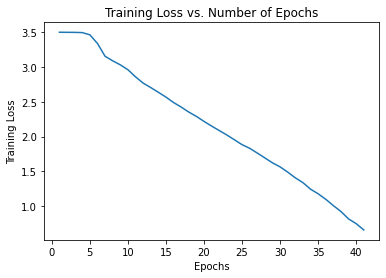

In [45]:
from matplotlib import pyplot as plt

num_epochs = range(1, len(training_loss_arr) + 1)

plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title("Training Loss vs. Number of Epochs")
plt.plot(num_epochs, training_loss_arr)
plt.savefig('training_loss.png', dpi=1200)

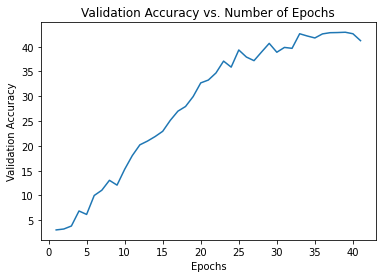

In [53]:
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy vs. Number of Epochs")
plt.plot(num_epochs, val_accuracy_arr)
plt.savefig('val_accuracy.png', dpi=1200)

In [56]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5, 0.5, 0.5])])
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

testset_new = ImageFolderWithPaths(root= test_data_dir, transform=transform)
testloader_new = torch.utils.data.DataLoader(testset_new, batch_size=16,
                                         shuffle=False, num_workers=2)

In [69]:
def find_classes(dir):
    classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx

classes, class_to_idx = find_classes(test_data_dir)

def get_differences(testloader, model):
    res = []
    with torch.no_grad():
        for data in (testloader):
            images, labels, paths = data
            if torch.cuda.is_available():
                images, labels = images.cuda(), labels.cuda()        
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            for i in range(len(labels)):
                label = labels[i]
                pred = predicted[i]
                if label!=pred:
                    res.append({
                        "fpath": paths[i],
                        "pred": classes[pred.cpu().item()],
                        "label": classes[label.cpu().item()]
                    })
    return res

res = get_differences(testloader_new,net)

In [79]:
import random
from PIL import Image
import io
random.shuffle(res)

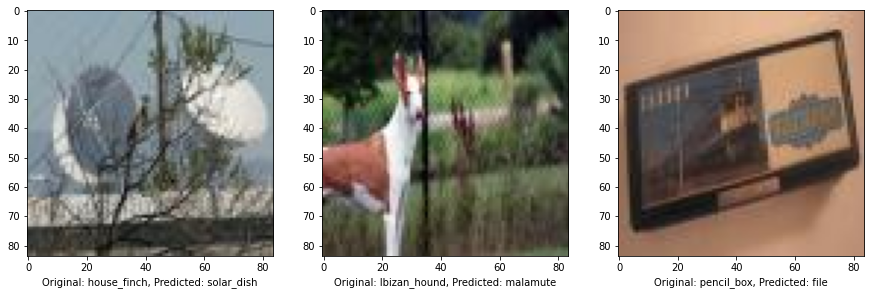

In [84]:
def read_img(img_path):
    with open(img_path, 'rb') as f:
        image_bytes = f.read()
        image = Image.open(io.BytesIO(image_bytes))
    return np.asarray(image)

f, axarr = plt.subplots(1,3, figsize=(15,5))
for i in range(3):
    axarr[i].imshow(read_img(res[i]['fpath']))
    axarr[i].set_xlabel(f"Original: {res[i]['label']}, Predicted: {res[i]['pred']}")

plt.show()

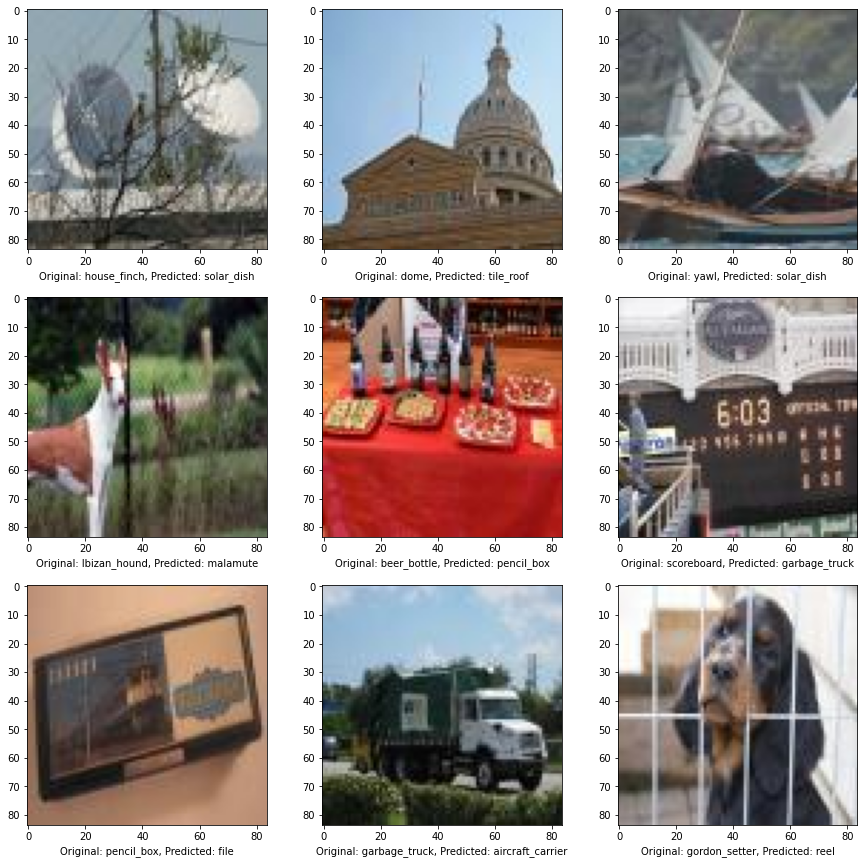

In [89]:
def read_img(img_path):
    with open(img_path, 'rb') as f:
        image_bytes = f.read()
        image = Image.open(io.BytesIO(image_bytes))
    return np.asarray(image)

f, axarr = plt.subplots(3,3, figsize=(15,15))
for i in range(3):
    for j in range(3):
        axarr[j,i].imshow(read_img(res[i*3+j]['fpath']))
        axarr[j,i].set_xlabel(f"Original: {res[i*3+j]['label']}, Predicted: {res[i*3+j]['pred']}")
plt.savefig("wrong_preds.png", dpi=1200)